<span style="font-size: 15px;">
 ----------------------------------------------------------------- <br>
 Project: House Prices Prediction <br>
 Author: Jairo Macedo <br>
 Created: June 2024 <br>
 Last Modified: [04, 2025] | By: Jairo Macedo <br>
 ----------------------------------------------------------------- <br>
 Description: <br>
 This Python notebook contains the code and analysis for the project <br>
 <b>House Prices Prediction</b>. The goal is to model and predict house prices <br>
 using a variety of property features. The dataset comes from a Kaggle <br>
 competition and includes rich details about homes and their sale prices. <br>
 ----------------------------------------------------------------- <br>
 The analysis is structured as follows: <br>
 1. Data Import and Exploration: Loading and understanding the dataset. <br>
 2. Feature Engineering: Creating and selecting relevant variables. <br>
 3. Modeling: Applying and tuning machine learning models to predict prices. <br>
 4. Evaluation: Assessing model performance and accuracy. <br>
 5. Submission: Preparing results for Kaggle submission. <br>
 ----------------------------------------------------------------- <br>

<br>
<b>Clean Dataset Files</b> <br>
- <code>train_2.csv</code> – The cleaned and preprocessed training set <br>
- <code>test_2.csv</code> – The cleaned and preprocessed test set <br>
</span>



# Packages ⚙️ and data 🗂️

In [128]:
# ================================
# Data Handling and Utilities
# ================================
import pandas as pd                      # Data manipulation
import numpy as np                       # Numerical operations
import zipfile                           # Reading compressed .zip files
import math                              # Basic math functions

from support import zip_path             # Path to the .zip file
from support import path         # Path for saving results
from support import plot_categorical_boxplots  # Custom plotting function
from support import analyze_cat_vs_price  # Custom plotting function

from support import plot_categorical_boxplots  # Custom plotting function
from support import plot_comp_histogram_boxplot  # Custom plotting function

# ================================
# Visualization
# ================================
import matplotlib.pyplot as plt          # Plotting
import seaborn as sns                    # Statistical data visualization

# ================================
# Machine Learning Models
# ================================
from sklearn.model_selection import train_test_split   # Train/test split
from sklearn.linear_model import LinearRegression      # Linear Regression model
from sklearn import tree                               # Decision Tree Regressor
from sklearn.neighbors import KNeighborsRegressor      # KNN Regressor

# ================================
# Model Evaluation Metrics
# ================================
from sklearn.metrics import mean_absolute_error        # MAE
from sklearn.metrics import mean_squared_error         # MSE
from sklearn.metrics import r2_score                   # R²

# ================================
# Aesthetics
# ================================
# Custom color (dark wine red)
red_color = (162 / 255, 37 / 255, 56 / 255)





import os

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OrdinalEncoder




In [129]:
# Setting the global random seed for reproducibility
np.random.seed(42)

In [130]:
# Open the zip and read train.csv directly
with zipfile.ZipFile(zip_path) as z:
    with z.open('train.csv') as f:
        df_train = pd.read_csv(f)

In [131]:
# Open the zip and read test.csv directly
with zipfile.ZipFile(zip_path) as z:
    with z.open('test.csv') as f:
        df_test = pd.read_csv(f)

# Hi, data! 👋

## Train data

### Step 1

In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [133]:
# Check Train data for missing values (Top 20)
missing_percent = (df_train.isnull().sum() / df_train.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

PoolQC          99.52%
MiscFeature     96.30%
Alley           93.77%
Fence           80.75%
MasVnrType      59.73%
FireplaceQu     47.26%
LotFrontage     17.74%
GarageQual       5.55%
GarageFinish     5.55%
GarageType       5.55%
GarageYrBlt      5.55%
GarageCond       5.55%
BsmtFinType2     2.60%
BsmtExposure     2.60%
BsmtCond         2.53%
BsmtQual         2.53%
BsmtFinType1     2.53%
MasVnrArea       0.55%
Electrical       0.07%
Condition2       0.00%
dtype: object


<a id='4top'></a>

- **The first 4 columns have more than 80% missing values in the training set**
    - Instead of dropping these columns, let's understand what each one represents:
        - **PoolQC**: **Quality** of the pool  
            - NA: No Pool  
        - **MiscFeature**: Miscellaneous features not covered in other categories  
            - NA: None  
        - **Alley**: Type of alley access to the property  
            - NA: No alley access  
        - **Fence**: **Quality** of the fence  
            - NA: No Fence  

- In these cases, **NA is not missing data, <font color= '#A22538' >it is information</font>**

- Therefore, we should explore the values in these columns and their **relationship with the sale price**


In [134]:
# We can replace the missing values in the first column with -1
df_train[['PoolQC','MiscFeature','Alley','Fence']] = df_train[['PoolQC','MiscFeature','Alley','Fence']].fillna(-1)

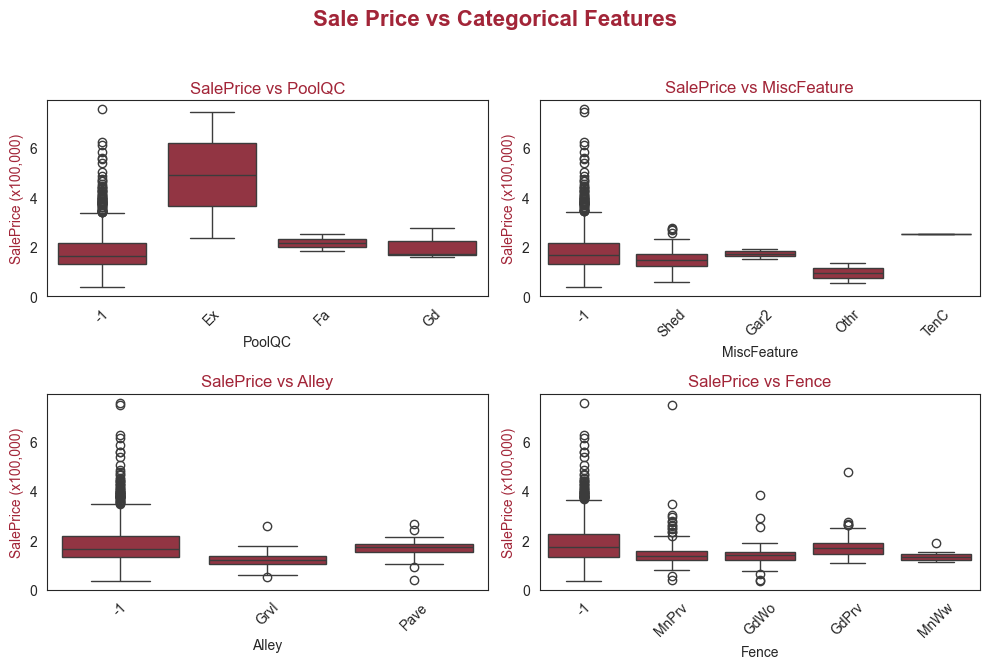

In [135]:
# Plot boxplots showing the relationship between SalePrice and selected categorical features
plot_categorical_boxplots(
    df=df_train,
    cat_vars=['PoolQC', 'MiscFeature', 'Alley', 'Fence'],
    target='SalePrice',
    color=red_color,
    title='Sale Price vs Categorical Features',
    figsize=(10, 7)
)

We can see that houses with excellent pool quality (‘Ex’) clearly exhibit higher sale prices, indicating that this feature significantly adds value to the property.

<a id='FireplaceQu'></a>
- **<font color='#A22538'>FireplaceQu</font>: Fireplace quality**  
  - There are two fireplace-related columns:  
    - **Fireplaces**: Number of fireplaces  
    - **FireplaceQu**: Quality of the fireplace, if present  
  - **Ex**: Excellent – Exceptional masonry fireplace  
  - **Gd**: Good – Masonry fireplace on main level  
  - **TA**: Average – Prefabricated fireplace in living area or masonry in basement  
  - **Fa**: Fair – Prefabricated fireplace in basement  
  - **Po**: Poor – Ben Franklin stove  
  - **NA**: No fireplace present  
    <!-- Missing values here are genuine: they indicate absence of a fireplace -->


In [136]:
# Visualizing the number of fireplaces
df_train[['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            690
1           Gd             324
            TA             259
2           Gd              54
            TA              53
1           Fa              28
            Po              20
            Ex              19
2           Fa               4
            Ex               4
3           Gd               2
            Ex               1
            Fa               1
            TA               1
Name: count, dtype: int64

In [137]:
# Adjusting this column
# This NaN is also meaningful — it indicates that "there is no fireplace"
df_train[['FireplaceQu']] = df_train[['FireplaceQu']].fillna(-1)

<a id='LotFrontage'></a>
- **<font color='#A22538'>LotFrontage</font>: Linear feet of street connected to the property**  
  - Missing values are likely due to data omission, not true absence of frontage.  
  - They will be imputed using the neighborhood mean to preserve geographic consistency.

<a id='LotConfig'></a>
- **<font color='#A22538'>LotConfig</font>: Lot configuration**  
  - **Inside**: Inside lot, surrounded by other lots with no street corner  
  - **Corner**: Corner lot, facing two intersecting streets  
  - **CulDSac**: Located in a cul-de-sac, offering more privacy  
  - **FR2**: Frontage on two sides of the property  
  - **FR3**: Frontage on three sides of the property

In [138]:
# Understanding the types of properties with missing values
df_train.loc[df_train.LotFrontage.isnull(), 'LotConfig'].value_counts()

LotConfig
Inside     134
Corner      62
CulDSac     49
FR2         14
Name: count, dtype: int64

In [139]:
# Checking the average LotFrontage by property type
df_train.groupby('LotConfig')['LotFrontage'].mean()

LotConfig
Corner     84.039801
CulDSac    59.911111
FR2        63.515152
FR3        70.750000
Inside     67.715686
Name: LotFrontage, dtype: float64

In [140]:
# Missing values in LotFrontage are likely due to data recording issues, not absence of frontage
# Imputing missing values using the mean LotFrontage grouped by LotConfig (preserves contextual variation)
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(
    df_train.groupby('LotConfig')['LotFrontage'].transform('mean'))

<a id="garagem"></a>
- **Evaluating the <font color='#A22538'>garage-related columns</font>**
    - **GarageType**: Garage location  
        - **NA: No Garage**  
    - **GarageYrBlt**: Year garage was built  
    - **GarageFinish**: Interior finish of the garage  
        - **NA: No Garage**  
    - **GarageCars**: Size of garage in car capacity
    - **GarageArea**: Size of garage in square feet
    - **GarageQual**: Garage quality  
        - **NA: No Garage**  
    - **GarageCond**: Garage condition  
        - **NA: No Garage**

In [141]:
# Checking for columns that contain 'Garage' in their name
col_garage = df_train.columns[df_train.columns.str.contains("Garage")]

# Filtering the dataset
df_train.loc[df_train.GarageType.isnull(), col_garage].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0           0           NaN         NaN           81
Name: count, dtype: int64

In [142]:
# We can select only the columns with missing values
df_train.loc[df_train.GarageType.isnull(), col_garage[[0,1,2,3,4,5,6]]].head(3)  

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN


In [143]:
# Loop to check whether, when one column is NaN, the others are also NaN
for col in col_garage:
    print(f"\nChecking when '{col}' is NaN:")
    
    # Filter rows where the current column is NaN
    subset = df_train.loc[df_train[col].isna(), col_garage]
    
    # Count the patterns of NaN values across the garage-related columns
    pattern_counts = subset.isna().value_counts(dropna=False)
    print(pattern_counts)


Checking when 'GarageType' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True        True         True          False       False       True        True          81
Name: count, dtype: int64

Checking when 'GarageYrBlt' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True        True         True          False       False       True        True          81
Name: count, dtype: int64

Checking when 'GarageFinish' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True        True         True          False       False       True        True          81
Name: count, dtype: int64

Checking when 'GarageCars' is NaN:
Series([], Name: count, dtype: int64)

Checking when 'GarageArea' is NaN:
Series([], Name: count, dtype: int64)

Checking when 'GarageQual' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True   

In [144]:
# Replace these values with -1
df_train.loc[df_train.GarageType.isnull(), col_garage[[0,1,2,5,6]]] = -1

In [145]:
# Checking again when the number of cars is equal to 0
df_train.loc[df_train.GarageCars == 0, col_garage].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
-1          -1.0         -1            0           0           -1          -1            81
Name: count, dtype: int64

<a id="basement"></a>
- **Evaluating the <font color= '#A22538' >basement-related columns</font>**
    - **NA: No Basement**

In [146]:
# Checking for columns that contain 'Bsmt' in their name
col_Bsmt = df_train.columns[df_train.columns.str.contains("Bsmt") & (df_train.isnull().any())]

col_Bsmt

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], dtype='object')

In [147]:
# Loop to check whether, when one column is NaN, the others are also NaN
for col in col_Bsmt:
    print(f"\nChecking when '{col}' is NaN:")
    
    # Filter rows where the current column is NaN
    subset = df_train.loc[df_train[col].isna(), col_Bsmt]
    
    # Count the patterns of NaN values across the garage-related columns
    pattern_counts = subset.isna().value_counts(dropna=False)
    print(pattern_counts)


Checking when 'BsmtQual' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
True      True      True          True          True            37
Name: count, dtype: int64

Checking when 'BsmtCond' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
True      True      True          True          True            37
Name: count, dtype: int64

Checking when 'BsmtExposure' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
True      True      True          True          True            37
False     False     True          False         False            1
Name: count, dtype: int64

Checking when 'BsmtFinType1' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
True      True      True          True          True            37
Name: count, dtype: int64

Checking when 'BsmtFinType2' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
True      True      True          True          True            37
False  

<a id="basement2"></a>

- **BsmtFinType2**: Rating of basement finished area (if multiple types)  
    - **GLQ**: Good Living Quarters  
    - **ALQ**: Average Living Quarters  
    - **BLQ**: Below Average Living Quarters  
    - **Rec**: Average Rec Room  
    - **LwQ**: Low Quality  
    - **Unf**: Unfinished  
    - **NA**: No Basement  

- **BsmtFinSF2**: Type 2 finished square feet

In [148]:
# Analyzing the values
df_train.loc[df_train.BsmtFinType2.isnull(), col_Bsmt].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Gd        TA        No            GLQ           NaN              1
Name: count, dtype: int64

In [149]:
# Checking the value combinations of 'BsmtFinType2' and 'BsmtFinSF2' where 'BsmtFinType2' is missing
df_train.loc[df_train.BsmtFinType2.isnull(), ['BsmtFinType2', 'BsmtFinSF2']].value_counts(dropna=False)

BsmtFinType2  BsmtFinSF2
NaN           0             37
              479            1
Name: count, dtype: int64

It doesn't make sense for **BsmtFinType2** to indicate that there is no basement (NA) while **BsmtFinSF2** reports a positive area value.

In [150]:
# Analyzing the values for BsmtExposure
df_train.BsmtFinType2.value_counts()

BsmtFinType2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64

In [151]:
# Checking the mode of BsmtFinType2
mod_BsmtFinType2 = df_train.BsmtFinType2.mode()[0]
mod_BsmtFinType2

'Unf'

In [152]:
# Replacing missing values with 'Unf' where BsmtFinSF2 is not 0
df_train.loc[(df_train.BsmtFinType2.isnull()) & (df_train.BsmtFinSF2 != 0), 'BsmtFinType2'] = mod_BsmtFinType2

In [153]:
# Replace these values with -1
df_train.loc[df_train.BsmtQual.isnull(), col_Bsmt] = -1

<a id="bsmt_exposure"></a>

- **Now let's investigate the last basement-related variable: `BsmtExposure`**

- **BsmtExposure**: Refers to walkout or garden level walls  
    - **Gd**: Good Exposure  
    - **Av**: Average Exposure (split levels or foyers typically score average or above)  
    - **Mn**: Minimum Exposure  
    - **No**: No Exposure  
    - **NA**: No Basement  


In [154]:
# Analyzing the values for BsmtExposure
df_train.BsmtExposure.value_counts()

BsmtExposure
No    953
Av    221
Gd    134
Mn    114
-1     37
Name: count, dtype: int64

In [155]:
# And again, we can see the most frequent value
mod_BsmtExposure = df_train.BsmtExposure.mode()[0]
mod_BsmtExposure

'No'

In [156]:
# Replacing missing values with "No" (the most frequent value)
df_train.loc[df_train.BsmtExposure.isnull(), 'BsmtExposure'] = mod_BsmtExposure

In [157]:
# Verifying null values in the set
df_train.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType     872
MasVnrArea       8
Electrical       1
MSSubClass       0
LotArea          0
Street           0
MSZoning         0
LotFrontage      0
LandContour      0
Utilities        0
dtype: int64

<a id='MasVnrType'></a>  
- **Now analyzing the <font color='#A22538'>MasVnrType</font> column**  
- This column refers to the **type of masonry veneer** used in the house:  
    - **BrkCmn**: Brick Common  
    - **BrkFace**: Brick Face  
    - **CBlock**: Cinder Block  
    - **None**: No veneer  
    - **Stone**: Stone veneer

In [158]:
# Filtering the dataset
df_train.loc[df_train.MasVnrType.isnull(),['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
1,NaN,0.0
3,NaN,0.0
5,NaN,0.0
8,NaN,0.0
9,NaN,0.0
...,...,...
1454,NaN,0.0
1455,NaN,0.0
1457,NaN,0.0
1458,NaN,0.0


There shouldn't be cases where MasVnrArea has a positive value but MasVnrType is missing. Therefore, we fill MasVnrType with its unconditional mode only for rows where MasVnrArea is not null and MasVnrType is null.

In [159]:
masvnrtype_mode = df_train['MasVnrType'].mode()[0]

mask = (df_train['MasVnrType'].isnull()) & (df_train['MasVnrArea'] > 0)

df_train.loc[mask, 'MasVnrType'] = masvnrtype_mode

In [160]:
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)

In [161]:
df_train['MasVnrType'].value_counts()

MasVnrType
None       867
BrkFace    450
Stone      128
BrkCmn      15
Name: count, dtype: int64

<a id=''></a>
- **Analyzing the remaining train dataset**
- **Understanding these columns**
    - **<font color='#A22538'>MSZoning</font>**: Area where the house is located  
        - NA: The information was not added to the dataset (missing information)
    - **<font color='#A22538'>Functional</font>**: House functionalities  
        - NA: The information was not added to the dataset (missing information)
    - **<font color='#A22538'>Utilities</font>**: Available utilities  
        - NA: The information was not added to the dataset (missing information)


In [162]:
df_train['Electrical'].value_counts(dropna=False)

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: count, dtype: int64

In [163]:
# Checking the mode of Electrical
mod_Electrical = df_train.Electrical.mode()[0]

# Replacing missing values in the Electrical column
df_train.loc[df_train.Electrical.isnull(), 'Electrical'] = mod_Electrical

In [164]:
# Check Train data for missing values (Top 20)
missing_percent = (df_train.isnull().sum() / df_train.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

Id              0.00%
MSSubClass      0.00%
MSZoning        0.00%
LotFrontage     0.00%
LotArea         0.00%
Street          0.00%
Alley           0.00%
LotShape        0.00%
LandContour     0.00%
Utilities       0.00%
LotConfig       0.00%
LandSlope       0.00%
Neighborhood    0.00%
Condition1      0.00%
Condition2      0.00%
BldgType        0.00%
HouseStyle      0.00%
OverallQual     0.00%
OverallCond     0.00%
YearBuilt       0.00%
dtype: object


## Test data

### Step 1

In [165]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [166]:
# Check Test data for missing values (Top 20)
missing_percent = (df_test.isnull().sum() / df_test.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

PoolQC          99.79%
MiscFeature     96.50%
Alley           92.67%
Fence           80.12%
MasVnrType      61.27%
FireplaceQu     50.03%
LotFrontage     15.56%
GarageYrBlt      5.35%
GarageCond       5.35%
GarageFinish     5.35%
GarageQual       5.35%
GarageType       5.21%
BsmtCond         3.08%
BsmtQual         3.02%
BsmtExposure     3.02%
BsmtFinType1     2.88%
BsmtFinType2     2.88%
MasVnrArea       1.03%
MSZoning         0.27%
BsmtHalfBath     0.14%
dtype: object


In [167]:
# We can replace the missing values in the first column with -1
df_test[['PoolQC','MiscFeature','Alley','Fence']] = df_test[['PoolQC','MiscFeature','Alley','Fence']].fillna(-1)

<a id='FireplaceQu'></a>
- **Now analyzing the <font color='#A22538'>FireplaceQu</font> column**
- There are 2 fireplace-related columns:
    - **Fireplaces**: Number of fireplaces  
    - **FireplaceQu**: Fireplace quality

In [168]:
# Visualizing the number of records in each label
df_test[['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            730
1           Gd             303
            TA             236
2           Gd              58
            TA              39
1           Fa              35
            Po              26
            Ex              18
2           Fa               6
3           TA               3
            Gd               3
2           Ex               1
4           TA               1
Name: count, dtype: int64

In [169]:
# Adjusting this column
# This NaN is also meaningful — it indicates that there is no fireplace
df_test[['FireplaceQu']] = df_test[['FireplaceQu']].fillna(-1)

<a id='LotFrontage'></a>
- **<font color='#A22538'>LotFrontage</font>: Linear feet of street connected to the property**  
  - Missing values are likely due to data omission, not true absence of frontage.  
  - They will be imputed using the neighborhood mean to preserve geographic consistency.

<a id='LotConfig'></a>
- **<font color='#A22538'>LotConfig</font>: Lot configuration**  
  - **Inside**: Inside lot, surrounded by other lots with no street corner  
  - **Corner**: Corner lot, facing two intersecting streets  
  - **CulDSac**: Located in a cul-de-sac, offering more privacy  
  - **FR2**: Frontage on two sides of the property  
  - **FR3**: Frontage on three sides of the property

In [170]:
# Understanding the types of properties with missing values
df_test.loc[df_test.LotFrontage.isnull(), 'LotConfig'].value_counts()

LotConfig
Inside     137
Corner      42
CulDSac     38
FR2          6
FR3          4
Name: count, dtype: int64

In [171]:
# Checking the average LotFrontage by property type
df_test.groupby('LotConfig')['LotFrontage'].mean()

LotConfig
Corner     81.373786
CulDSac    53.568182
FR2        58.968750
FR3        85.000000
Inside     66.709746
Name: LotFrontage, dtype: float64

In [172]:
# Missing values in LotFrontage are likely due to data recording issues, not absence of frontage
# Imputing missing values using the mean LotFrontage grouped by LotConfig (preserves contextual variation)
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(
    df_test.groupby('LotConfig')['LotFrontage'].transform('mean'))

<a id="garagem"></a>
- **Evaluating the <font color='#A22538'>garage-related columns</font>**
    - **GarageType**: Garage location  
        - **NA: No Garage**  
    - **GarageYrBlt**: Year garage was built  
    - **GarageFinish**: Interior finish of the garage  
        - **NA: No Garage**  
    - **GarageCars**: Size of garage in car capacity
    - **GarageArea**: Size of garage in square feet
    - **GarageQual**: Garage quality  
        - **NA: No Garage**  
    - **GarageCond**: Garage condition  
        - **NA: No Garage**

In [173]:
# Checking for columns that contain 'Garage' in their name
col_garage = df_test.columns[df_test.columns.str.contains("Garage")]

# Filtering the dataset
df_test.loc[df_test.GarageType.isnull(), col_garage].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0.0         0.0         NaN         NaN           76
Name: count, dtype: int64

In [174]:
# Loop to check whether, when one column is NaN, the others are also NaN
for col in col_garage:
    print(f"\nChecking when '{col}' is NaN:")
    
    # Filter rows where the current column is NaN
    subset = df_test.loc[df_test[col].isna(), col_garage]
    
    # Count the patterns of NaN values across the garage-related columns
    pattern_counts = subset.isna().value_counts(dropna=False)
    print(pattern_counts)


Checking when 'GarageType' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True        True         True          False       False       True        True          76
Name: count, dtype: int64

Checking when 'GarageYrBlt' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True        True         True          False       False       True        True          76
False       True         True          False       False       True        True           1
                                       True        True        True        True           1
Name: count, dtype: int64

Checking when 'GarageFinish' is NaN:
GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
True        True         True          False       False       True        True          76
False       True         True          False       False       True        True           1
                           

In [175]:
# If GarageType is NaN, then GarageFinish, GarageQual, and GarageCond are also assumed to be NaN
# In those cases, replace the selected garage-related columns with -1

df_test.loc[df_test.GarageType.isnull(), col_garage[[0,1,2,5,6]]] = -1

In [176]:
# Filtering the dataset
df_test.loc[df_test.GarageYrBlt.isnull(), col_garage].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
Detchd      NaN          NaN           1.0         360.0       NaN         NaN           1
                                       NaN         NaN         NaN         NaN           1
Name: count, dtype: int64

<a id="garagem"></a>

- **Now let's investigate the rows where all garage-related columns are empty but `GarageType` is <font color='#A22538'>Detchd</font>**
    - **GarageType**: Garage location  
        - **2Types**: More than one type of garage  
        - **Attchd**: Attached to home  
        - **Basment**: Basement garage  
        - **BuiltIn**: Built-in (garage is part of the house — typically with a room above)  
        - **CarPort**: Car port  
        - **Detchd**: Detached from home  
        - **NA**: No garage 

In [177]:
# Let's check how many rows have all garage-related columns missing when `GarageType` is Detchd:
df_test.loc[df_test.GarageCond.isnull(), col_garage].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
Detchd      NaN          NaN           1.0         360.0       NaN         NaN           1
                                       NaN         NaN         NaN         NaN           1
Name: count, dtype: int64

The presence of values in GarageCars and GarageArea indicates that the property has a garage.

- Now let's investigate column GarageYrBlt

In [178]:
# 1. Filter the DataFrame to include only detached garages (Detchd) with valid year built
df_test2 = df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageYrBlt != -1)]

# 2. Select only numeric columns to avoid "could not convert string to float" error
df_test_numeric = df_test2.select_dtypes(include='number')

# 3. Calculate the correlation of all numeric variables with 'GarageYrBlt'
top_corrs = df_test_numeric.corr()['GarageYrBlt'].sort_values(ascending=False).head(5)
print(top_corrs)

GarageYrBlt     1.000000
YearBuilt       0.615951
GarageArea      0.494670
GarageCars      0.413711
YearRemodAdd    0.321667
Name: GarageYrBlt, dtype: float64


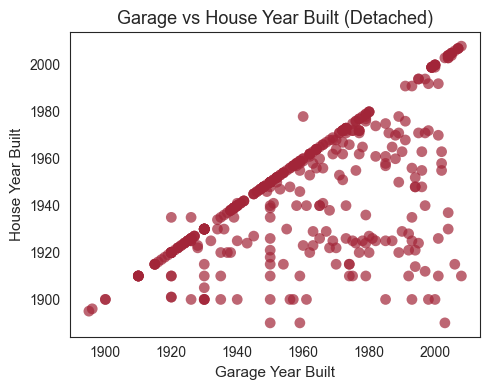

In [179]:
# Set up a smaller figure
fig, ax = plt.subplots(figsize=(5, 4))  # smaller size

# Scatter plot
ax.scatter(df_test_numeric.GarageYrBlt, df_test_numeric.YearBuilt, color=red_color, alpha=0.7, edgecolors='none', s=60)

# Labels and title
ax.set_xlabel('Garage Year Built', fontsize=11)
ax.set_ylabel('House Year Built', fontsize=11)
ax.set_title('Garage vs House Year Built (Detached)', fontsize=13)

# No grid
ax.grid(False)

# Clean layout
plt.tight_layout()
plt.show()

In [180]:
# Create a new column that checks if the garage year is the same as the house year
df_test['CheckYears'] = df_test.GarageYrBlt == df_test.YearBuilt

# Count how many times the condition is True or False
df_test.CheckYears.value_counts()

CheckYears
True     1127
False     332
Name: count, dtype: int64

In [181]:
# Checking the values when there is no garage
df_test.loc[(df_test.CheckYears == False) & (df_test.GarageYrBlt == -1)].shape[0]

76

In most cases where a garage exists, it appears to have been built at the same time as the house.

In [182]:
df_test = df_test.drop('CheckYears',axis=1)

In [183]:
# Check the house construction years for rows where GarageCond is missing
df_test.loc[df_test.GarageCond.isnull(), 'YearBuilt']

666     1910
1116    1923
Name: YearBuilt, dtype: int64

In [184]:
# Replace missing GarageYrBlt values with the house's construction year (YearBuilt)
df_test.loc[df_test.GarageCond.isnull(), 'GarageYrBlt'] = df_test.loc[df_test.GarageCond.isnull(), 'YearBuilt']

We used two closely related columns — the year the house was built and the year the garage was built — and used one to validate the other.

In [185]:
# Let's check how many rows have all garage-related columns missing when `GarageType` is Detchd:
df_test.loc[df_test.GarageFinish.isnull(), col_garage].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
Detchd      1910.0       NaN           1.0         360.0       NaN         NaN           1
            1923.0       NaN           NaN         NaN         NaN         NaN           1
Name: count, dtype: int64

<a id="garagem"></a>

- **GarageFinish**: Interior finish of the garage
    - **Fin**: Finished
    - **RFn**: Rough Finished
    - **Unf**: Unfinished 
    - **NA**: No garage 

In [186]:
# Check the most frequent values of GarageFinish when GarageType is 'Detchd'
df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageFinish'].value_counts()

GarageFinish
Unf    365
RFn     15
Fin     10
Name: count, dtype: int64

In [187]:
# Get the mode of GarageFinish for 'Detchd' garage type and there is only one value as the most common
most_common_finish = df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageFinish'].mode()[0]
print(most_common_finish)

Unf


In [188]:
# Replace missing GarageFinish values with the mode, only for 'Detchd' garages
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageFinish.isnull()), 'GarageFinish'] = most_common_finish

<a id="garagem"></a>

Now let's investigate:
- **GarageQual**: Garage quality  
    - **Ex**: Excellent  
    - **Gd**: Good  
    - **TA**: Typical/Average  
    - **Fa**: Fair  
    - **Po**: Poor  
    - **NA**: No Garage  

- **GarageCond**: Garage condition  
    - **Ex**: Excellent  
    - **Gd**: Good  
    - **TA**: Typical/Average  
    - **Fa**: Fair  
    - **Po**: Poor  
    - **NA**: No Garage 

In [189]:
# Check value combinations of GarageQual and GarageCond when GarageType is 'Detchd'
df_test.loc[(df_test.GarageType == 'Detchd'), ['GarageQual', 'GarageCond']].value_counts()

GarageQual  GarageCond
TA          TA            309
Fa          TA             38
            Fa             19
TA          Fa             16
Fa          Po              3
Gd          Ex              1
Po          Po              1
            Fa              1
TA          Gd              1
            Po              1
Name: count, dtype: int64

There may have been issues during the audit process that introduced bias into the data, possibly leading evaluators to record values that did not reflect the actual conditions.

In [190]:
# Get the mode for GarageQual and GarageCond among 'Detchd' garages
mode_garage_qual = df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageQual'].mode()[0]
mode_garage_cond = df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageCond'].mode()[0]
print(mode_garage_qual, mode_garage_cond)

TA TA


In [191]:
# Replace missing GarageQual values with the most common one
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageQual.isnull()), 'GarageQual'] = mode_garage_qual
# Replace missing GarageCond values with the most common one
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageCond.isnull()), 'GarageCond'] = mode_garage_cond

<a id="garagem"></a>

Now let's investigate:
- **GarageCars**: Size of garage in car capacity

- **GarageArea**: Size of garage in square feet 

In [192]:
# Calculate the mean of GarageCars and GarageArea for detached garages
mean_values = df_test.loc[df_test.GarageType == 'Detchd', ['GarageCars', 'GarageArea']].mean()
print(mean_values)

GarageCars      1.519182
GarageArea    412.202046
dtype: float64


In [193]:
# We can't have half a car!
mean_values = round(mean_values, 0)
print(mean_values.values)

[  2. 412.]


In [194]:
# Fill missing values ONLY for GarageCars and GarageArea, for detached garages
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageCars.isnull()), 'GarageCars'] = mean_values['GarageCars']
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageArea.isnull()), 'GarageArea'] = mean_values['GarageArea']

In [195]:
# Check how those values look in specific rows
df_test.iloc[[666, 1116], 55:70]

,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch
666,Typ,0,-1,Detchd,1910.0,Unf,1.0,360.0,TA,TA,Y,64,0,180,0
1116,Typ,0,-1,Detchd,1923.0,Unf,2.0,412.0,TA,TA,Y,174,0,212,0


We have now completed the analysis of the garage-related variables.

<a id="basement"></a>
- **Evaluating the <font color= '#A22538' >basement-related columns</font>**
    - **NA: No Basement**

In [196]:
# Checking for columns that contain 'Bsmt' in their name
col_Bsmt = df_test.columns[df_test.columns.str.contains("Bsmt") & (df_test.isnull().any())]

col_Bsmt

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [197]:
# Loop to check whether, when one column is NaN, the others are also NaN
for col in col_Bsmt:
    print(f"\nChecking when '{col}' is NaN:")
    
    # Filter rows where the current column is NaN
    subset = df_test.loc[df_test[col].isna(), col_Bsmt]
    
    # Count the patterns of NaN values across the garage-related columns
    pattern_counts = subset.isna().value_counts(dropna=False)
    print(pattern_counts)


Checking when 'BsmtQual' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
True      True      True          True          False       True          False       False      False        False         False           40
          False     False         False         False       False         False       False      False        False         False            2
          True      True          True          False       True          False       False      False        True          True             1
                                                True        True          True        True       True         True          True             1
Name: count, dtype: int64

Checking when 'BsmtCond' is NaN:
BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
True      True      True          True          False       

- Evaluating the BsmtQual

In [198]:
# Selecting rows where BsmtQual is missing but BsmtCond is present, we cannot fill it with -1, because -1 means "No basement"
df_test.loc[(df_test.BsmtQual.isnull()) & (df_test.BsmtCond.notnull()),col_Bsmt]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


In [199]:
# Fill missing values in BsmtQual using the conditional mode

df_test.groupby(['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])['BsmtQual'].transform(lambda x : pd.Series.mode(x)[0])

0       TA
1       TA
2       Gd
3       Gd
4       TA
        ..
1454    TA
1455    TA
1456    TA
1457    Gd
1458    Gd
Name: BsmtQual, Length: 1459, dtype: object

In [200]:
# Compute the mode for each group
groupwise_mode = df_test.groupby(['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])['BsmtQual']\
                        .transform(lambda x: pd.Series.mode(x)[0])

# Create a mask for rows where BsmtQual is missing but BsmtCond is present
mask = (df_test['BsmtQual'].isnull()) & (df_test['BsmtCond'].notnull())

# Fill only those values
df_test.loc[mask, 'BsmtQual'] = groupwise_mode[mask]


In [201]:
df_test.iloc[757:759,30:40]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
757,TA,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA
758,TA,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA


In [202]:
# Now, let's check the values of BsmtQual when it's missing
df_test.loc[df_test.BsmtQual.isnull(),col_Bsmt].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
                                                                                                              NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
Name: count, dtype: int64

In [203]:
df_test.loc[df_test.BsmtQual.isnull(),['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = 0

df_test.loc[df_test.BsmtQual.isnull(),['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = -1

- Evaluating the BsmtCond

In [204]:
df_test.loc[df_test.BsmtCond.isnull(),col_Bsmt].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Gd        NaN       Mn            GLQ           1044.0      Rec           382.0       0.0        1426.0       1.0           0.0             1
TA        NaN       Av            ALQ           755.0       Unf           0.0         240.0      995.0        0.0           0.0             1
                    No            BLQ           1033.0      Unf           0.0         94.0       1127.0       0.0           1.0             1
Name: count, dtype: int64

In [205]:
df_test.BsmtCond.mode()[0]
df_test.loc[df_test.BsmtCond.isnull(),'BsmtCond'] = df_test.BsmtCond.mode()[0]

- Evaluating the BsmtExposure

In [206]:
df_test.loc[df_test.BsmtExposure.isnull(),col_Bsmt].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Gd        TA        NaN           Unf           0.0         Unf           0.0         725.0      725.0        0.0           0.0             1
                                                                                      1595.0     1595.0       0.0           0.0             1
Name: count, dtype: int64

In [207]:
df_test.loc[df_test.BsmtExposure.isnull(),col_Bsmt].value_counts(dropna=False)
df_test.loc[df_test.BsmtExposure.isnull(),'BsmtExposure'] = df_test.BsmtExposure.mode()[0]

In [208]:
# Verifying null values in the set
df_test.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType     894
MasVnrArea      15
MSZoning         4
Utilities        2
Functional       2
Exterior1st      1
SaleType         1
KitchenQual      1
Exterior2nd      1
LotShape         0
dtype: int64

<a id='MasVnrType'></a>  
- **Now analyzing the <font color='#A22538'>MasVnrType</font> column**  
- This column refers to the **type of masonry veneer** used in the house:  
    - **BrkCmn**: Brick Common  
    - **BrkFace**: Brick Face  
    - **CBlock**: Cinder Block  
    - **None**: No veneer  
    - **Stone**: Stone veneer

In [209]:
# Filtering the dataset
df_test.loc[df_test.MasVnrType.isnull(),['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
0,NaN,0.0
2,NaN,0.0
4,NaN,0.0
5,NaN,0.0
6,NaN,0.0
...,...,...
1453,NaN,0.0
1454,NaN,0.0
1455,NaN,0.0
1456,NaN,0.0


There shouldn't be cases where MasVnrArea has a positive value but MasVnrType is missing. Therefore, we fill MasVnrType with its unconditional mode only for rows where MasVnrArea is not null and MasVnrType is null.

In [210]:
masvnrtype_mode = df_test['MasVnrType'].mode()[0]

mask = (df_test['MasVnrType'].isnull()) & (df_test['MasVnrArea'] > 0)

df_test.loc[mask, 'MasVnrType'] = masvnrtype_mode

In [211]:
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

In [212]:
df_test['MasVnrType'].value_counts(dropna=False)

MasVnrType
None       891
BrkFace    437
Stone      121
BrkCmn      10
Name: count, dtype: int64

- We know that depending on the variable, imputing missing values with the mode may not always be the best choice. For instance, if there are outliers or skewed distributions, the median might be a better alternative.

- However, since the number of missing values is small, this approach is unlikely to have a significant impact on model performance.

In [213]:
cols_to_fill = ['MSZoning', 'KitchenQual','Utilities' ,'Functional', 'SaleType', 'Exterior2nd', 'Exterior1st']

for col in cols_to_fill:
    mode_value = df_test[col].mode()[0]
    df_test[col] = df_test[col].fillna(mode_value)

In [214]:
# Check Train data for missing values (Top 20)
missing_percent = (df_test.isnull().sum() / df_test.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

Id              0.00%
MSSubClass      0.00%
MSZoning        0.00%
LotFrontage     0.00%
LotArea         0.00%
Street          0.00%
Alley           0.00%
LotShape        0.00%
LandContour     0.00%
Utilities       0.00%
LotConfig       0.00%
LandSlope       0.00%
Neighborhood    0.00%
Condition1      0.00%
Condition2      0.00%
BldgType        0.00%
HouseStyle      0.00%
OverallQual     0.00%
OverallCond     0.00%
YearBuilt       0.00%
dtype: object


# General 1

In [215]:
# We segment the dataset by its categorical columns in order to assess their relationship with price 
# and then handle them in the main analysis.

obj_cols = df_train.columns[df_train.dtypes == 'object'].tolist()
cols_to_copy = obj_cols + ['SalePrice']
df_train2 = df_train[cols_to_copy].copy()

In [216]:
# ──────────────────────────────────────────────────────────────────────────────
# Create a new “price_band” column by cutting SalePrice into four equal‑frequency
# bins (quartiles), and label them “cheap”, “medium”, “upper‑medium”, “expensive”.
# ──────────────────────────────────────────────────────────────────────────────
labels = ['cheap', 'medium', 'upper‑medium', 'expensive']
df_train2['price_band'] = pd.qcut(
    df_train2['SalePrice'],
    q=[0, .25, .5, .75, 1.0],
    labels=labels)

In [217]:
# ──────────────────────────────────────────────────────────────────────────────
# Now we analyze the association of each categorical variable with price_band:
# we compute Cramer's V for every categorical column and rank them by
# strongest vs. weakest association.
# ──────────────────────────────────────────────────────────────────────────────

def cramers_v(confusion_matrix):
    """
    Returns Cramer's V statistic for a given contingency table.
    Applies bias correction as in Bergsma & Wicher (2013).
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 1) Ensure price_band is treated as string
df_train2['price_band'] = df_train2['price_band'].astype(str)

results = []
for col in df_train2.columns[df_train2.dtypes == 'object']:
    if col == 'price_band':
        continue

    # build contingency table
    ct = pd.crosstab(df_train2['price_band'], df_train2[col])
    if ct.shape[1] < 2:
        continue

    # chi‑squared test
    chi2, p, _, _ = chi2_contingency(ct)

    # compute Cramer's V
    v = cramers_v(ct)

    results.append({
        'variable': col,
        'p_value': p,
        'cramers_v': v
    })

# 2) Build a DataFrame and sort by descending Cramer's V, then ascending p‑value
res = pd.DataFrame(results)
res = res.sort_values(['cramers_v', 'p_value'], ascending=[False, True]).reset_index(drop=True)

# 3) Display the top 10 variables with the strongest association
rank = res.tail(10)
print(rank)

       variable   p_value  cramers_v
33   Functional  0.000094   0.084706
34    ExterCond  0.000035   0.082671
35    LotConfig  0.000067   0.080285
36     RoofMatl  0.034950   0.054813
37       Street  0.110233   0.045545
38   Condition2  0.112223   0.042942
39    LandSlope  0.086700   0.041618
40  MiscFeature  0.246229   0.025779
41       PoolQC  0.427916   0.004681
42    Utilities  0.394681   0.000000


In [218]:
# Display value counts for Utilities in df_train with a label
print("Utilities value counts in df_train:")
print(df_train.Utilities.value_counts().sort_values(ascending=False))

# Display value counts for Utilities in df_test with a label
print("\nUtilities value counts in df_test:")
print(df_test.Utilities.value_counts().sort_values(ascending=False))

Utilities value counts in df_train:
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

Utilities value counts in df_test:
Utilities
AllPub    1459
Name: count, dtype: int64


The `Utilities` column clearly has minimal importance, as indicated by its low Cramer's V value. Therefore, we can safely drop it from the dataset.

In [219]:
df_train = df_train.drop('Utilities',axis=1)
df_test = df_test.drop('Utilities',axis=1)

<a id='centralair-analysis'></a>
- **Upon inspecting the training set, we see that the <font color='#A22538'>CentralAir</font> feature is binary (Y/N) and may have a strong influence on SalePrice. Let’s explore this relationship.**


In [220]:
df_train.CentralAir.value_counts()

CentralAir
Y    1365
N      95
Name: count, dtype: int64

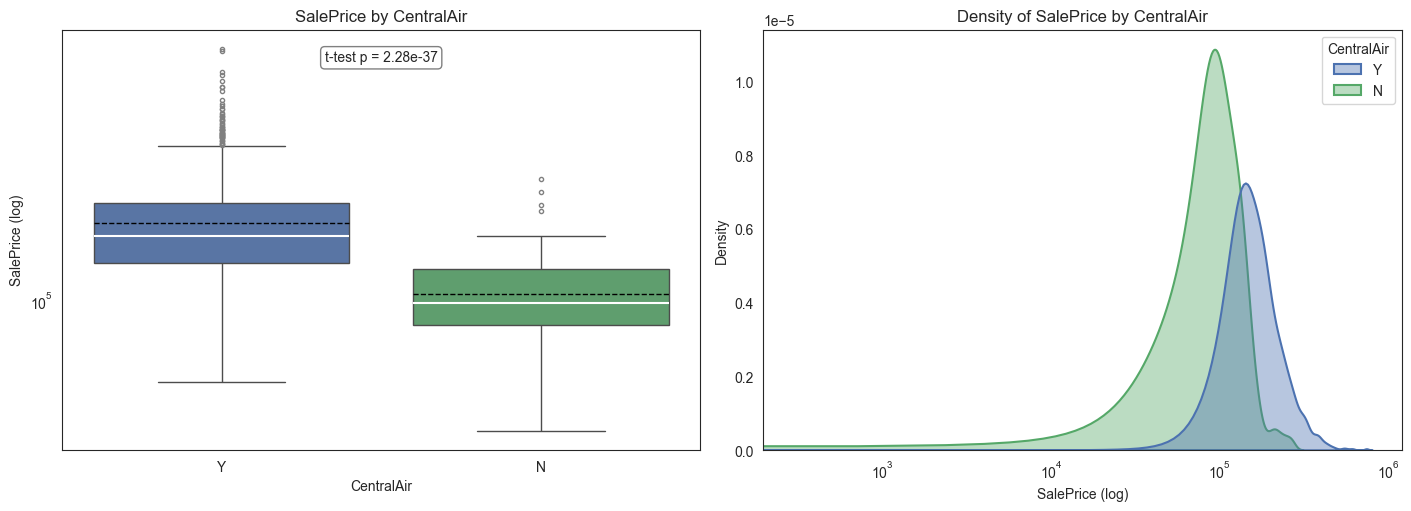

In [221]:
test_name, pval = analyze_cat_vs_price(
    df_train2,
    cat_col='CentralAir',
    palette={"Y":"#4C72B0","N":"#55A868"},
    nonparametric=False
)


The t‑test annotation (p ≈ 2 × 10⁻³⁷) confirms that the difference in means is overwhelmingly significant

In [222]:
# Simple binary flag without backup column on both datasets
df_train['CentralAir'] = (df_train['CentralAir'] == 'Y').astype(int)

df_test['CentralAir'] = (df_test['CentralAir'] == 'Y').astype(int)

<a id='centralair-analysis'></a>
- **Now, let's check <font color='#A22538'>PavedDrive</font>**


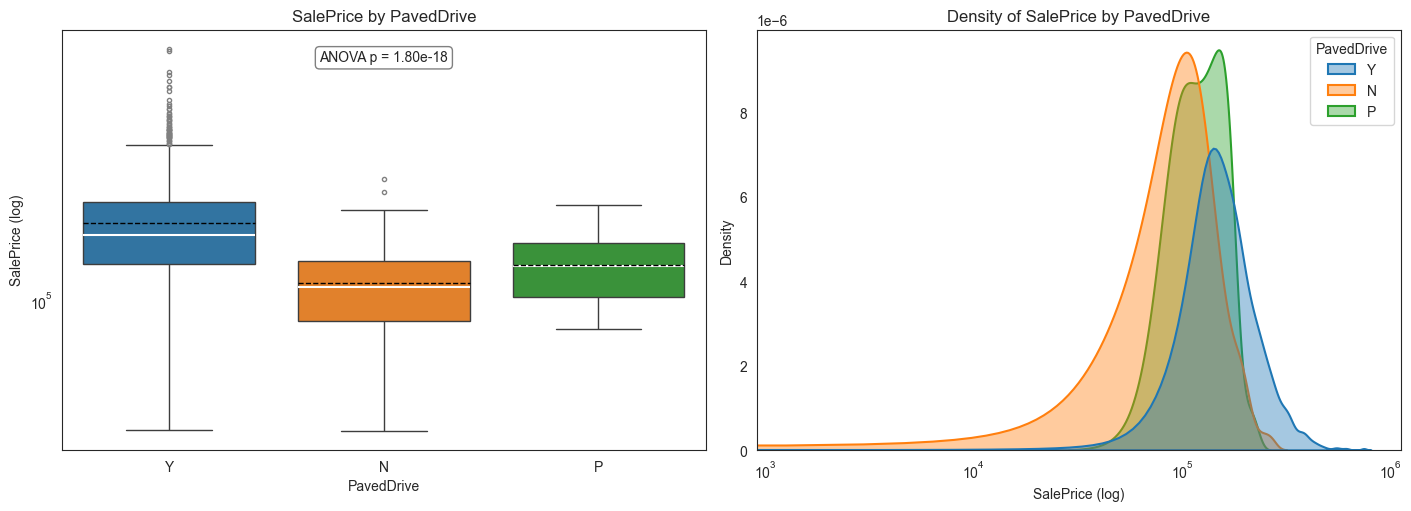

In [223]:
test_name, pval = analyze_cat_vs_price(
    df_train2,
    cat_col='PavedDrive',
    nonparametric=False
)

In [224]:
# Mapping function
def DefinePavedDrive(x):
    if x == 'Y':
        return 1.0
    elif x == 'P':
        return 0.5
    elif x == 'N':
        return 0.0
    else:
        return -1.0

df_train['PavedDrive'] = df_train.PavedDrive.apply(DefinePavedDrive)

df_test['PavedDrive'] = df_test.PavedDrive.apply(DefinePavedDrive)

<a id="MSZoning"></a>

- Evaluating the <span style="color:#A22538">MSZoning</span> column

**MSZoning** identifies the general zoning classification of the sale. Possible values:

| Code | Description                              |
|:-----|:-----------------------------------------|
| A    | Agriculture                              |
| C    | Commercial                               |
| FV   | Floating Village Residential             |
| I    | Industrial                               |
| RH   | Residential High Density                 |
| RL   | Residential Low Density                  |
| RP   | Residential Low Density Park             |
| RM   | Residential Medium Density               |

In [225]:
df_train.groupby('MSZoning')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
MSZoning,,,,,,,,
C (all),10.0,74528.000000,33791.092031,34900.0,43998.25,74700.0,98332.0,133900.0
FV,65.0,214014.061538,52369.662067,144152.0,174000.00,205950.0,250000.0,370878.0
RH,16.0,131558.375000,35714.118435,76000.0,106150.00,136500.0,148608.5,200000.0
RL,1151.0,191004.994787,80766.341319,39300.0,137700.00,174000.0,224700.0,755000.0
RM,218.0,126316.830275,48521.689833,37900.0,100000.00,120500.0,140000.0,475000.0


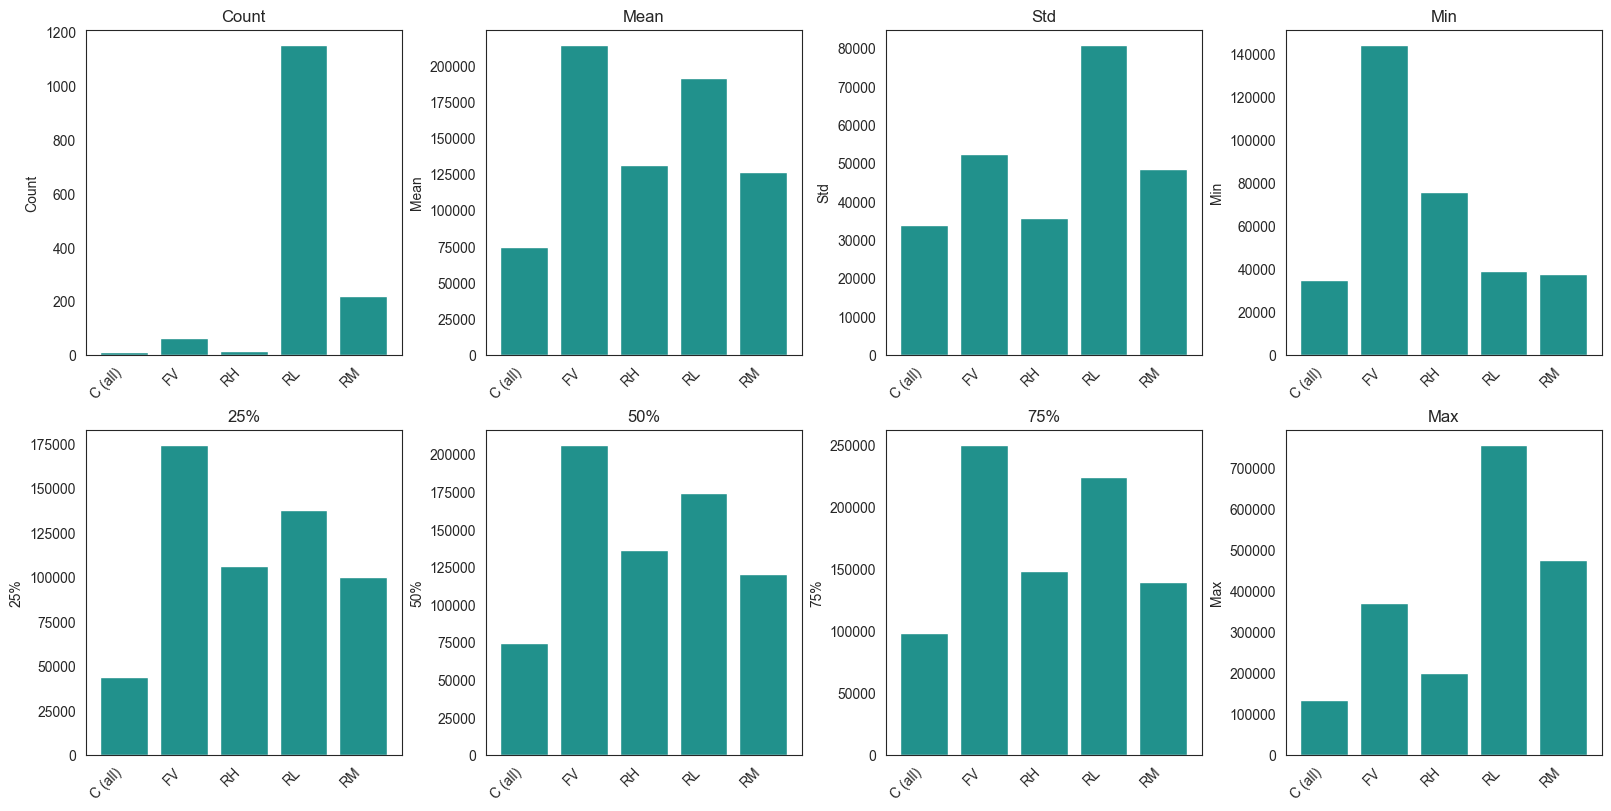

In [226]:
# 2) Compute the grouped describe table
stats = df_train2.groupby('MSZoning')['SalePrice'].describe()

# 3) Stats to visualize
stats_cols = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# 4) Single bar color
bar_color = sns.color_palette("viridis", 1)[0]

# 5) Create subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
axes = axes.flatten()

for ax, col in zip(axes, stats_cols):
    vals = stats[col].values
    cats = stats.index.tolist()
    
    # draw bars
    ax.bar(cats, vals, color=bar_color)
    ax.set_title(col.capitalize())
    ax.set_ylabel(col.capitalize())
    
    # set ticks THEN labels
    ax.set_xticks(range(len(cats)))
    ax.set_xticklabels(cats, rotation=45, ha='right')

plt.show()


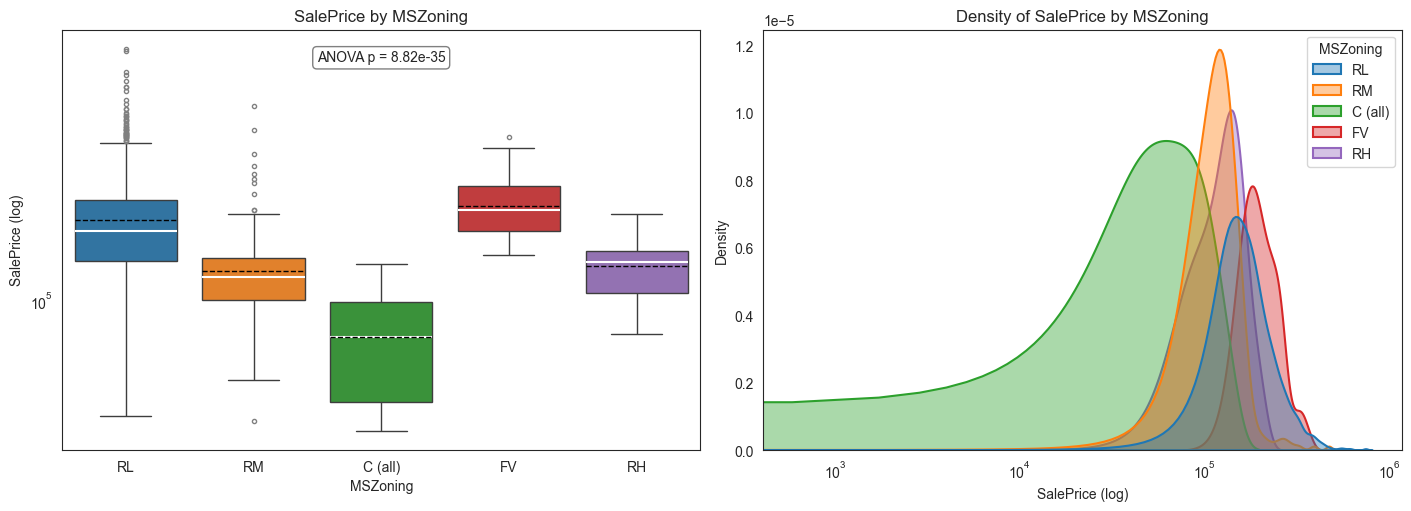

In [227]:
test_name, pval = analyze_cat_vs_price(
    df_train2,
    cat_col='MSZoning',
    nonparametric=False
)

To address the issue of textual variables, we can now apply a OneHotEncoder to convert each category into its own new column

In [228]:
# For train data

# instantiate with the new parameter name
ohe_MSZoning = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit once
ohe_MSZoning.fit(df_train[['MSZoning']])

# transform and build DataFrame
arr = ohe_MSZoning.transform(df_train[['MSZoning']])
cols = ohe_MSZoning.get_feature_names_out(['MSZoning'])
ohe_MSZoning_df = pd.DataFrame(arr, columns=cols, index=df_train.index)

# concatenate and drop original
df_train = pd.concat([df_train, ohe_MSZoning_df], axis=1).drop(columns=['MSZoning'])


# For test data

# instantiate with the new parameter name
ohe_MSZoning = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit once
ohe_MSZoning.fit(df_test[['MSZoning']])

# transform and build DataFrame
arr = ohe_MSZoning.transform(df_test[['MSZoning']])
cols = ohe_MSZoning.get_feature_names_out(['MSZoning'])
ohe_MSZoning_df = pd.DataFrame(arr, columns=cols, index=df_test.index)

# concatenate and drop original
df_test = pd.concat([df_test, ohe_MSZoning_df], axis=1).drop(columns=['MSZoning'])


<a id="GarageQual"></a>

- Evaluating the <span style="color:#A22538">GarageQual</span> column


In [229]:
df_train.GarageQual.value_counts()

GarageQual
TA    1311
-1      81
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64

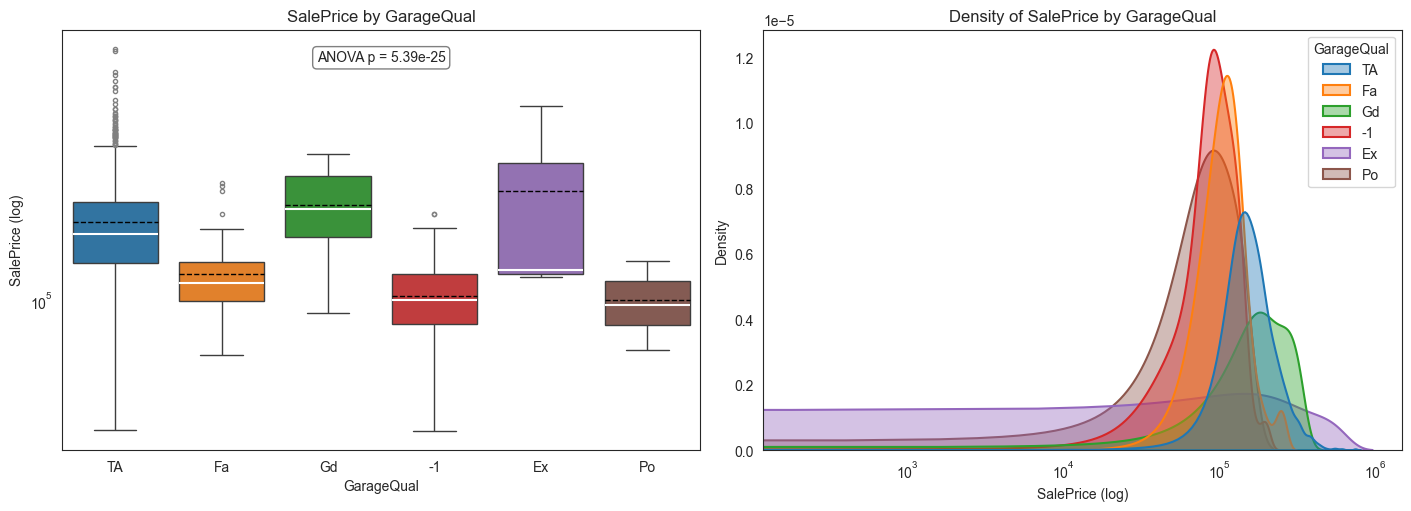

In [230]:
test_name, pval = analyze_cat_vs_price(
    df_train2,
    cat_col='GarageQual',
    nonparametric=False
)

By examining the data_description file, we noticed there are multiple garage-related columns (as also identified during Data Cleaning). We can now visualize these garage features.

In [231]:
col_garage = df_train.columns[df_train.columns.str.contains("Garage")]

df_train[col_garage].head(5)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA


Could it be that GarageQual and GarageCond are representing the same information?

In [232]:
df_train[['GarageQual','GarageCond']].value_counts()

GarageQual  GarageCond
TA          TA            1291
-1          -1              81
Fa          TA              24
            Fa              20
TA          Fa              15
Gd          TA              10
TA          Gd               5
Fa          Po               4
Gd          Gd               4
Po          Po               3
Ex          Ex               2
            TA               1
Name: count, dtype: int64

In [233]:
# Count the proportion of rows where GarageQual equals GarageCond
(df_train['GarageQual'] == df_train['GarageCond']).mean().round(2)

np.float64(0.96)

In [234]:
# Drop GarageCond from the dataset as 96% of the rows have the same value as GarageQual
df_train = df_train.drop('GarageCond',axis=1)

In [235]:
df_test = df_test.drop('GarageCond',axis=1)

<a id="GarageArea"></a>

- Evaluating the <span style="color:#A22538">GarageArea</span> column


In [236]:
df_train[['GarageCars','GarageArea','SalePrice']].corr()

,GarageCars,GarageArea,SalePrice
GarageCars,1.000000,0.882475,0.640409
GarageArea,0.882475,1.000000,0.623431
SalePrice,0.640409,0.623431,1.000000


In [237]:
# As GarageCars is more correlated with SalePrice, we will keep it and drop GarageArea
df_train = df_train.drop('GarageArea',axis=1)

In [238]:
df_test = df_test.drop('GarageArea',axis=1)

- We can continue processing the garage columns, but relate them to other dataset features such as YearBuilt and YearRemodAdd

In [239]:
df_train[['GarageYrBlt','YearBuilt','YearRemodAdd','SalePrice']].corr()

,GarageYrBlt,YearBuilt,YearRemodAdd,SalePrice
GarageYrBlt,1.000000,0.272009,0.146341,0.261354
YearBuilt,0.272009,1.000000,0.592855,0.522897
YearRemodAdd,0.146341,0.592855,1.000000,0.507101
SalePrice,0.261354,0.522897,0.507101,1.000000


GarageYrBlt and YearBuilt shows a weak relationship

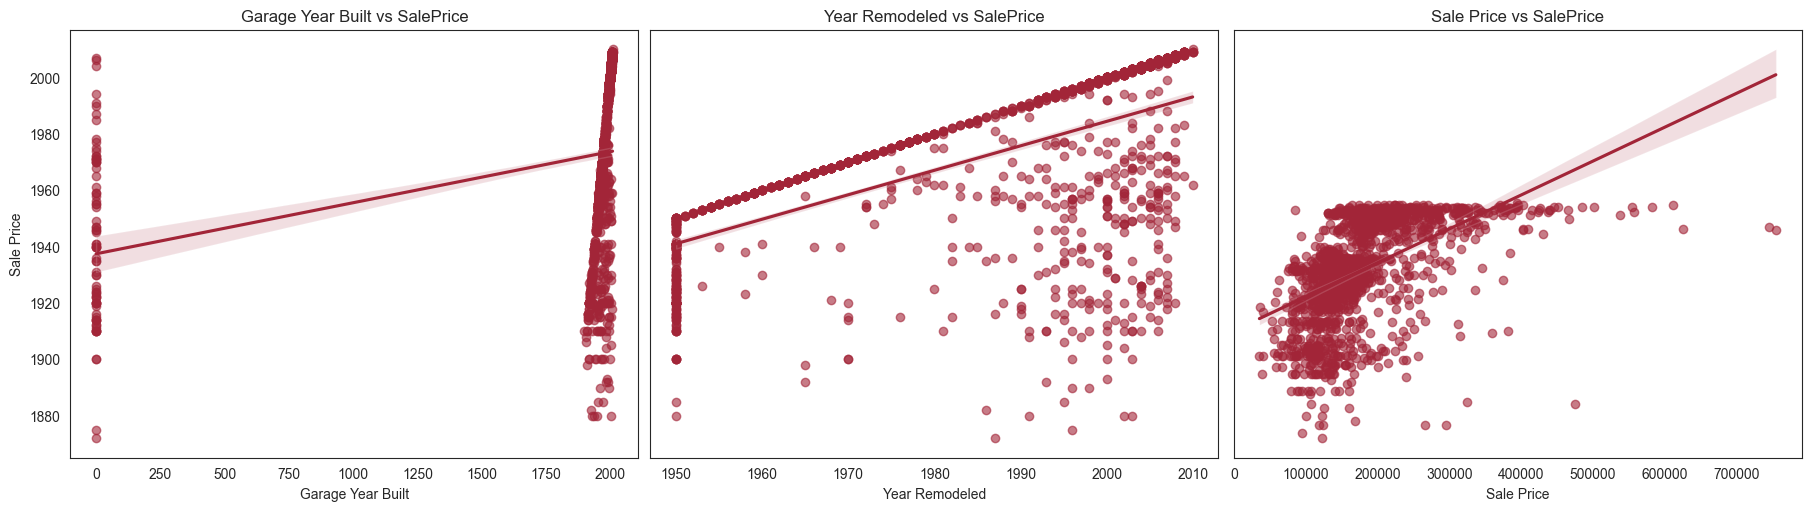

In [240]:
# Remove seaborn grid style
sns.set_style("white")

# Criando os subplots
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), constrained_layout=True)

features = ['GarageYrBlt','YearRemodAdd','SalePrice']

titles   = ['Garage Year Built', 'Year Remodeled', 'Sale Price']

for i in range(3):
    sns.regplot(
        data=df_train,
        x=features[i],
        y='YearBuilt',
        ax=ax[i],
        scatter_kws={'alpha': 0.6, 'color': red_color},
        line_kws={'color': red_color},  # Ainda aparece a linha de tendência
    )
    ax[i].set_title(f'{titles[i]} vs SalePrice', fontsize=12)
    ax[i].set_xlabel(titles[i])
    ax[i].set_ylabel('Sale Price' if i == 0 else '')
    ax[i].grid(False)  # Remove grid
    if i > 0:
        ax[i].set_yticklabels([])

plt.show()

In [241]:
df_train.loc[df_train.GarageYrBlt != -1,['GarageYrBlt','YearBuilt','YearRemodAdd','SalePrice']].corr()

,GarageYrBlt,YearBuilt,YearRemodAdd,SalePrice
GarageYrBlt,1.000000,0.825667,0.642277,0.486362
YearBuilt,0.825667,1.000000,0.618058,0.507584
YearRemodAdd,0.642277,0.618058,1.000000,0.505434
SalePrice,0.486362,0.507584,0.505434,1.000000


In [242]:
# Drop GarageYrBlt from the dataset as it is not useful for our analysis
df_train = df_train.drop('GarageYrBlt',axis=1)

In [243]:
df_test = df_test.drop('GarageYrBlt',axis=1)

- GarageType

In [244]:
df_train.GarageType.value_counts()

GarageType
Attchd     870
Detchd     387
BuiltIn     88
-1          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [245]:
# For train data

# 1) Instantiate the encoder (with modern parameters)
ohe_garage = OneHotEncoder(
    handle_unknown='ignore',
    min_frequency=25,
    sparse_output=False
)

# 2) Fit only on training data, making sure all values are strings
ohe_garage.fit(df_train[['GarageType']].astype(str))

# 3) Transform training data
arr_train = ohe_garage.transform(df_train[['GarageType']].astype(str))
cols = ohe_garage.get_feature_names_out(['GarageType'])
garage_ohe_train = pd.DataFrame(arr_train, columns=cols, index=df_train.index)

# 4) Concatenate encoded columns and drop original
df_train = pd.concat([df_train, garage_ohe_train], axis=1).drop(columns=['GarageType'])

In [246]:
# For test data

# 2) Fit only on test data, making sure all values are strings
ohe_garage.fit(df_test[['GarageType']].astype(str))

# 3) Transform test data
arr_test = ohe_garage.transform(df_test[['GarageType']].astype(str))
cols = ohe_garage.get_feature_names_out(['GarageType'])
garage_ohe_test = pd.DataFrame(arr_test, columns=cols, index=df_test.index)

# 4) Concatenate encoded columns and drop original
df_test = pd.concat([df_test, garage_ohe_test], axis=1).drop(columns=['GarageType'])

- Let's apply the **OrdinalEncoder** to the other two columns:
    - **GarageFinish**: Interior finish of the garage  
        - Fin: Finished  
        - RFn: Rough Finished  
        - Unf: Unfinished  
        - NA: No Garage → we will use -1
    - **GarageQual**: Garage quality  
        - Ex: Excellent  
        - Gd: Good  
        - TA: Typical/Average  
        - Fa: Fair  
        - Po: Poor  
        - NA: No Garage

In [247]:
# For train data
# 1) Define the category order for each column
GarageFinish_order = ['Unf', 'RFn', 'Fin']
GarageQual_order   = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

# 2) Instantiate the encoder
oe_garage = OrdinalEncoder(
    categories=[GarageFinish_order, GarageQual_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    dtype='int32'
)

# 3) Fit only on training data
oe_garage.fit(df_train[['GarageFinish', 'GarageQual']])

# 5) Transform training set
df_train[['GarageFinish', 'GarageQual']] = oe_garage.transform(df_train[['GarageFinish', 'GarageQual']])

In [248]:
# For test data

# 1) Define the category order for each column
GarageFinish_order = ['Unf', 'RFn', 'Fin']
GarageQual_order   = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

# 2) Instantiate the encoder
oe_garage = OrdinalEncoder(
    categories=[GarageFinish_order, GarageQual_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    dtype='int32'
)

# 3) Fit only on training data
oe_garage.fit(df_test[['GarageFinish', 'GarageQual']])

# 5) Transform training set
df_test[['GarageFinish', 'GarageQual']] = oe_garage.transform(df_test[['GarageFinish', 'GarageQual']])

## General 2

## Save data

In [249]:
df_train.to_csv(os.path.join(path, 'Data', 'train_2.csv'), index=False)
df_test.to_csv(os.path.join(path, 'Data', 'test_2.csv'), index=False)